# Predicting and Analyzing Urban Tree Health in Washington, D.C.

- Author: [Justin Schroder](https://github.com/SchroderJ-pixel)
- Repository: [Urban-Tree-Health-](https://github.com/SchroderJ-pixel/Urban-Tree-Health-)


---

## Section 1. Introduction

TODO: Remove this and customize your intro: Introduce the purpose of your project and provide background information on data sources, etc. 
The purpose of this notebook is to introduce notebooks for analytics. 
This is a Markdown cell (not a Python cell). 
Here are a few tips to help you get started with Jupyter Notebooks:

- To run a cell, press **Ctrl Enter** (or **Cmd Enter** on Mac) when you're done editing the cell.
- You can change the type of a cell (e.g., code or markdown) by looking in the lower left corner of the notebook interface.
- You can rearrange cells by dragging and dropping them within the notebook.
- After creating a new notebook, use **File > Save as** to rename and save it into your repository folder.
- To select a kernel (Python environment) for your notebook in Visual Studio Code, click on the **Select Kernel** name in the top-right corner of the notebook interface and choose the desired kernel from the dropdown menu. Follow suggestions to install recommended extensions. Once installed, click Select Kernel / Python Environments and choose the Recommended local project `.venv` created earlier. This will create a new kernel for the notebook and allow code to use the packages installed in the virtual environment.

---

## Section 2. Imports 

### 2.1 Import Libraries 

In [1]:
# 2.1 Imports
import os
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from folium.plugins import MarkerCluster, FastMarkerCluster

pd.set_option("display.float_format", lambda x: f"{x:.3f}")
sns.set_theme(context="notebook", style="whitegrid")


---

## Section 3 Data Setup & Description
### 3.1 Import & Load Dataset for 5M Urban Trees (Washington, D.C.)

In [2]:
# 2.2 Import Dataset
DATA_DIR = r"C:\Users\admin\OneDrive\Desktop\Masters\Capstone\Urban-Tree-Health\data"
CSV_PATH = os.path.join(DATA_DIR, "urban_trees.csv")
PARQUET_PATH = os.path.join(DATA_DIR, "urban_trees.parquet")

READ_KW = dict(
    infer_schema_length=50000,   # give Polars more rows to infer types
    null_values=["NA", "N/A", "", "na"],  # treat these as nulls
    try_parse_dates=True,
    ignore_errors=False,
)

if os.path.exists(PARQUET_PATH):
    df_pl = pl.read_parquet(PARQUET_PATH)
else:
    df_pl = pl.read_csv(CSV_PATH, **READ_KW)
    try:
        df_pl.write_parquet(PARQUET_PATH)
    except Exception as e:
        print("Skipped Parquet write:", e)

df = df_pl.to_pandas()
print("Data Loaded")
print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
df.head(10)



Data Loaded
Rows: 190,991 | Columns: 17


,city_ID,planted_date,most_recent_observation,common_name,scientific_name,city,state,longitude_coordinate,latitude_coordinate,address,ward,overhead_utility,diameter_breast_height_CM,condition,native,diameter_breast_height_binned_CM,greater_metro
0,15297-200-3001-0323-000,1/1/1970,1/15/2020,Pin oak,Quercus palustris,Washington DC,District of Columbia,-77.046,38.933,2020 Klingle rd Nw,1.000,No,67.310,good,naturally_occurring,60.96 to 76.2 cm,WashingtonDC
1,15297-200-3001-0279-000,1/1/1970,5/11/2020,Pin oak,Quercus palustris,Washington DC,District of Columbia,-77.046,38.933,2016 Klingle rd Nw,1.000,No,57.658,good,naturally_occurring,45.72 to 60.96 cm,WashingtonDC
2,36981-060-3001-0097-000,12/15/2014,12/30/2019,Nuttall oak,Quercus nuttallii,Washington DC,District of Columbia,-76.998,38.886,600 Pennsylvania Ave Se,6.000,No,12.700,good,None,0 to 15.24 cm,WashingtonDC
3,19048-300-3001-0321-000,1/1/1970,1/15/2020,Red oak,Quercus rubra,Washington DC,District of Columbia,-77.045,38.932,3226 Walbridge Pl Nw,1.000,No,27.940,good,naturally_occurring,15.24 to 30.48 cm,WashingtonDC
4,10170-310-3005-0211-000,1/1/1970,4/24/2019,Bradford callery pear,Pyrus calleryana,Washington DC,District of Columbia,-77.039,38.929,3105 17th St Nw,1.000,No,22.860,fair,introduced,15.24 to 30.48 cm,WashingtonDC
5,15297-200-3005-0194-000,1/1/1970,1/15/2020,Chinese elm,Ulmus parvifolia,Washington DC,District of Columbia,-77.046,38.933,2011 Klingle rd Nw,1.000,Yes,39.878,excellent,introduced,30.48 to 45.72 cm,WashingtonDC
6,30050-020-3001-0328-000,1/1/1970,12/14/2015,Littleleaf linden,Tilia cordata,Washington DC,District of Columbia,-76.999,38.887,226 5th St Se,6.000,No,36.576,good,introduced,30.48 to 45.72 cm,WashingtonDC
7,31982-060-3005-0468-000,12/4/2017,9/26/2018,Hackberry,Celtis occidentalis,Washington DC,District of Columbia,-76.997,38.886,649 C St Se,6.000,No,3.810,good,naturally_occurring,0 to 15.24 cm,WashingtonDC
8,17702-200-3005-0419-000,1/26/2018,1/15/2020,New harmony elm,Ulmus americana,Washington DC,District of Columbia,-77.047,38.934,2037 Rosemount Ave Nw,1.000,No,5.080,excellent,naturally_occurring,0 to 15.24 cm,WashingtonDC
9,16253-310-3005-0307-000,3/11/2010,4/24/2017,Plane tree,Platanus,Washington DC,District of Columbia,-77.038,38.930,3131 Mount Pleasant St Nw,1.000,No,10.160,fair,None,0 to 15.24 cm,WashingtonDC


### 3.2 Inspect & Describe Data

In [3]:
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190991 entries, 0 to 190990
Data columns (total 17 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   city_ID                           152650 non-null  object 
 1   planted_date                      190991 non-null  object 
 2   most_recent_observation           190991 non-null  object 
 3   common_name                       175862 non-null  object 
 4   scientific_name                   168005 non-null  object 
 5   city                              190991 non-null  object 
 6   state                             190991 non-null  object 
 7   longitude_coordinate              190989 non-null  float64
 8   latitude_coordinate               190989 non-null  float64
 9   address                           187618 non-null  object 
 10  ward                              190217 non-null  float64
 11  overhead_utility                  187524 non-null  o

native                              45701
city_ID                             38341
scientific_name                     22986
diameter_breast_height_binned_CM    20649
diameter_breast_height_CM           15872
common_name                         15129
condition                           15047
overhead_utility                     3467
address                              3373
ward                                  774
longitude_coordinate                    2
latitude_coordinate                     2
planted_date                            0
city                                    0
state                                   0
most_recent_observation                 0
greater_metro                           0
dtype: int64

---

## Section 4. Data Engieering

### 4.1 Handling Missing Data & NA Values

In [4]:
# Replace placeholder NA strings with true NaN
df = df.replace(["NA", "N/A", "n/a", "", " "], np.nan)

# Check missing values
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_counts)

# Define columns critical to your analysis
critical_cols = [
    "condition",
    "diameter_breast_height_CM",
    "native",
    "longitude_coordinate",
    "latitude_coordinate",
    "ward",
    "planted_date"
]

# Drop rows where any critical column is missing
df = df.dropna(subset=critical_cols).reset_index(drop=True)

print(f"\nCleaned dataset shape: {df.shape}")

Missing values per column:
 native                              45701
city_ID                             38513
scientific_name                     22986
diameter_breast_height_binned_CM    20649
diameter_breast_height_CM           15872
common_name                         15129
condition                           15051
overhead_utility                     3467
address                              3401
ward                                  774
longitude_coordinate                    2
latitude_coordinate                     2
planted_date                            0
city                                    0
state                                   0
most_recent_observation                 0
greater_metro                           0
dtype: int64

Cleaned dataset shape: (143467, 17)


### 4.2 Feature Creation & Type Conversion

In [5]:
df["planted_date"] = pd.to_datetime(df["planted_date"], errors="coerce")
current_year = datetime.now().year
df["tree_age"] = current_year - df["planted_date"].dt.year
df = df[df["tree_age"].notnull() & (df["tree_age"] >= 0)]
df["ward"] = df["ward"].astype("Int64")

print("tree_age and ward formatted")
df[["planted_date", "tree_age", "ward"]].head()

tree_age and ward formatted


,planted_date,tree_age,ward
0,1970-01-01,55.000,1
1,1970-01-01,55.000,1
2,1970-01-01,55.000,1
3,1970-01-01,55.000,1
4,1970-01-01,55.000,1


### 4.3 Encoding Categorical Variables

This step converts categorical text features into numeric values for modeling.  
The following conversions are performed:

1. **Binary Encoding –** Converts the `native` and `overhead_utility` columns from Yes/No text into binary numeric inputs:  
   - `0 = No`  
   - `1 = Yes`  

2. **Ordinal Encoding –** Encodes the `condition` column into an ordered scale (`condition_numeric`) for the Random Forest Classifier:  
   - `0 = dead/dying`  
   - `1 = poor`  
   - `2 = fair`  
   - `3 = good`  
   - `4 = excellent`  

3. **Binary Classification Variable –** Creates the `condition_binary` column for the Logistic Regression model, representing overall tree health:  
   - `0 = Unhealthy` (dead/dying, poor)  
   - `1 = Healthy` (fair, good, excellent)  

These encodings ensure that both models can interpret the tree condition appropriately:  
- The **Logistic Regression Model** uses `condition_binary` to classify trees as healthy or unhealthy.
- The **Random Forest Classifier** uses `condition_numeric` to predict all five health categories.  

In [6]:
df["native"] = df["native"].astype(str).str.strip().str.lower()
df["overhead_utility"] = df["overhead_utility"].astype(str).str.strip().str.lower()
df["condition"] = df["condition"].astype(str).str.strip().str.lower()

# Map native
native_map = {
    "naturally_occurring": 1,  # native
    "introduced": 0            # non-native
}
df["native"] = df["native"].map(native_map)

# Map overhead_utility
yes_no_map = {
    "yes": 1, "y": 1, "true": 1, "1": 1,
    "no": 0,  "n": 0, "false": 0, "0": 0
}
df["overhead_utility"] = df["overhead_utility"].map(yes_no_map)

# Map condition to ordinal
condition_map = {
    "dead/dying": 0,
    "poor": 1,
    "fair": 2,
    "good": 3,
    "excellent": 4
}
df["condition_numeric"] = df["condition"].map(condition_map)

# Binary condition for logistic regression
# 0 = Unhealthy (dead/dying, poor); 1 = Healthy (fair, good, excellent)
df["condition_binary"] = df["condition_numeric"].apply(lambda x: 1 if x >= 2 else 0)

print("Encoded categorical variables")
df[["native", "overhead_utility", "condition", "condition_numeric", "condition_binary"]].head()


Encoded categorical variables


,native,overhead_utility,condition,condition_numeric,condition_binary
0,1,0.000,good,3.000,1
1,1,0.000,good,3.000,1
2,1,0.000,good,3.000,1
3,0,0.000,fair,2.000,1
4,0,1.000,excellent,4.000,1


### 4.4 Verify Cleaned and Transformed Data

In [7]:
# Confirm data types are correct
print("Data types after data preparation:\n")
print(df.dtypes)
print("\n")

# Verify dataset structure
print(f"Total Rows: {len(df):,}")
print(f"Total Columns: {df.shape[1]}")
print(f"Column Names: {list(df.columns)}\n")

# Check for any remaining null or 'NA' values
print("🔍 Remaining missing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print("\n")

# Quick peek at a few rows for sanity check
print("Data preview:")
display(df.head(10))

print("\n Data verification complete — dataset is clean and ready for EDA.")

Data types after data preparation:

city_ID                                     object
planted_date                        datetime64[ns]
most_recent_observation                     object
common_name                                 object
scientific_name                             object
city                                        object
state                                       object
longitude_coordinate                       float64
latitude_coordinate                        float64
address                                     object
ward                                         Int64
overhead_utility                           float64
diameter_breast_height_CM                  float64
condition                                   object
native                                       int64
diameter_breast_height_binned_CM            object
greater_metro                               object
tree_age                                   float64
condition_numeric                          flo

,city_ID,planted_date,most_recent_observation,common_name,scientific_name,city,state,longitude_coordinate,latitude_coordinate,address,ward,overhead_utility,diameter_breast_height_CM,condition,native,diameter_breast_height_binned_CM,greater_metro,tree_age,condition_numeric,condition_binary
0,15297-200-3001-0323-000,1970-01-01,1/15/2020,Pin oak,Quercus palustris,Washington DC,District of Columbia,-77.046,38.933,2020 Klingle rd Nw,1,0.000,67.310,good,1,60.96 to 76.2 cm,WashingtonDC,55.000,3.000,1
1,15297-200-3001-0279-000,1970-01-01,5/11/2020,Pin oak,Quercus palustris,Washington DC,District of Columbia,-77.046,38.933,2016 Klingle rd Nw,1,0.000,57.658,good,1,45.72 to 60.96 cm,WashingtonDC,55.000,3.000,1
2,19048-300-3001-0321-000,1970-01-01,1/15/2020,Red oak,Quercus rubra,Washington DC,District of Columbia,-77.045,38.932,3226 Walbridge Pl Nw,1,0.000,27.940,good,1,15.24 to 30.48 cm,WashingtonDC,55.000,3.000,1
3,10170-310-3005-0211-000,1970-01-01,4/24/2019,Bradford callery pear,Pyrus calleryana,Washington DC,District of Columbia,-77.039,38.929,3105 17th St Nw,1,0.000,22.860,fair,0,15.24 to 30.48 cm,WashingtonDC,55.000,2.000,1
4,15297-200-3005-0194-000,1970-01-01,1/15/2020,Chinese elm,Ulmus parvifolia,Washington DC,District of Columbia,-77.046,38.933,2011 Klingle rd Nw,1,1.000,39.878,excellent,0,30.48 to 45.72 cm,WashingtonDC,55.000,4.000,1
5,30050-020-3001-0328-000,1970-01-01,12/14/2015,Littleleaf linden,Tilia cordata,Washington DC,District of Columbia,-76.999,38.887,226 5th St Se,6,0.000,36.576,good,0,30.48 to 45.72 cm,WashingtonDC,55.000,3.000,1
6,31982-060-3005-0468-000,2017-12-04,9/26/2018,Hackberry,Celtis occidentalis,Washington DC,District of Columbia,-76.997,38.886,649 C St Se,6,0.000,3.810,good,1,0 to 15.24 cm,WashingtonDC,8.000,3.000,1
7,17702-200-3005-0419-000,2018-01-26,1/15/2020,New harmony elm,Ulmus americana,Washington DC,District of Columbia,-77.047,38.934,2037 Rosemount Ave Nw,1,0.000,5.080,excellent,1,0 to 15.24 cm,WashingtonDC,7.000,4.000,1
8,10180-350-3001-0053-000,1970-01-01,4/10/2018,American elm,Ulmus americana,Washington DC,District of Columbia,-77.041,38.933,3324 18th St Nw,1,0.000,3.556,good,1,0 to 15.24 cm,WashingtonDC,55.000,3.000,1
9,15375-160-3001-0486-000,1970-01-01,11/20/2019,Siberian elm,Ulmus pumila,Washington DC,District of Columbia,-77.038,38.931,1654 Lamont St Nw,1,0.000,27.940,good,0,15.24 to 30.48 cm,WashingtonDC,55.000,3.000,1



 Data verification complete — dataset is clean and ready for EDA.


### 4.5 Created Features Data Cleanup

`condition_numeric` had 2,9993 missing entries and `condition_binary` had 754 missing.

In [8]:
# Drop rows missing
df = df.dropna(subset=["condition_numeric"]).reset_index(drop=True)
df = df.dropna(subset=["overhead_utility"])

print(f"Final dataset shape: {df.shape}")

Final dataset shape: (139760, 20)


### 4.6 Coordinate Verification (Longitude & Latitude)

In [9]:
# Confirm data types
print("Longitude dtype:", df["longitude_coordinate"].dtype)
print("Latitude dtype:", df["latitude_coordinate"].dtype)

# Check for null or invalid coordinates
print("\nMissing values:")
print(df[["longitude_coordinate", "latitude_coordinate"]].isnull().sum())

# Inspect coordinate ranges
lon_min, lon_max = df["longitude_coordinate"].min(), df["longitude_coordinate"].max()
lat_min, lat_max = df["latitude_coordinate"].min(), df["latitude_coordinate"].max()
print(f"\nLongitude range: {lon_min:.4f} → {lon_max:.4f}")
print(f"Latitude range:  {lat_min:.4f} → {lat_max:.4f}")

# 4Drop any rows outside expected Washington D.C. bounds
#    (Approximate city boundary box)
lon_min_valid, lon_max_valid = -77.2, -76.8
lat_min_valid, lat_max_valid = 38.7, 39.0

mask = (
    (df["longitude_coordinate"].between(lon_min_valid, lon_max_valid)) &
    (df["latitude_coordinate"].between(lat_min_valid, lat_max_valid))
)
dropped = len(df) - mask.sum()
df = df[mask].reset_index(drop=True)

print(f"\n Coordinate verification complete. Dropped {dropped} invalid rows (if any).")
print(f"Final dataset shape: {df.shape}")

Longitude dtype: float64
Latitude dtype: float64

Missing values:
longitude_coordinate    0
latitude_coordinate     0
dtype: int64

Longitude range: -77.1142 → -76.9096
Latitude range:  38.8152 → 38.9959

 Coordinate verification complete. Dropped 0 invalid rows (if any).
Final dataset shape: (139760, 20)


### **Section 4 Data Preparation Summary**
All data cleaning, transformation, and verification steps are complete.  
Key updates include:
- Removed missing or invalid entries for critical features.
- Converted categorical variables into numeric form.
- Created `tree_age`, `condition_numeric`, and `condition_binary` features.
- Verified coordinate accuracy within the Washington D.C. range.  

The final dataset contains **139,760 trees** and **20 features**, all ready for
exploratory data analysis, geospatial visualization, logistic regression model, and random forest classifier.

---

## Section 5 EDA

### 5.1 Basic Overview and Summary Statistics

This section summarizes the key numeric features in the dataset, including tree age, trunk diameter, ward, native status, and utility presence. Basic statistics such as the mean, median, minimum, maximum, and standard deviation are calculated to provide a general understanding of the data’s range and central tendencies.

In [10]:
numeric_cols = [
    "tree_age",
    "diameter_breast_height_CM",
    "ward",
    "native",
    "overhead_utility",
    "condition_numeric"
]

# Display basic descriptive statistics
print("Summary Statistics for Key Numeric Features:\n")
display(df[numeric_cols].describe().T)

# Optional: add median since describe() doesn’t include it
print("\nMedian Values:")
for col in numeric_cols:
    median_val = df[col].median()
    print(f"{col}: {median_val:.2f}")

print("\nSummary statistics generated successfully.")


Summary Statistics for Key Numeric Features:



,count,mean,std,min,25%,50%,75%,max
tree_age,139760.000,36.212,22.308,2.000,11.000,55.000,55.000,249.000
diameter_breast_height_CM,139760.000,26.094,24.615,0.000,6.350,17.272,37.846,251.460
ward,139760.000,4.646,2.053,1.000,3.000,5.000,6.000,8.000
native,139760.000,0.560,0.496,0.000,0.000,1.000,1.000,1.000
overhead_utility,139760.000,0.293,0.455,0.000,0.000,0.000,1.000,1.000
condition_numeric,139760.000,2.953,0.627,1.000,3.000,3.000,3.000,4.000



Median Values:
tree_age: 55.00
diameter_breast_height_CM: 17.27
ward: 5.00
native: 1.00
overhead_utility: 0.00
condition_numeric: 3.00

Summary statistics generated successfully.


### 5.2 Tree Health Distribution

This subsection visualizes how tree health is distributed across all condition levels. The first chart shows the count of trees in each ccondition (0-4). The second chart groups trees into healthy and unhealthy categories and counts the trees in the binary conditions. 

C:\Users\admin\AppData\Local\Temp\ipykernel_4184\2643655117.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


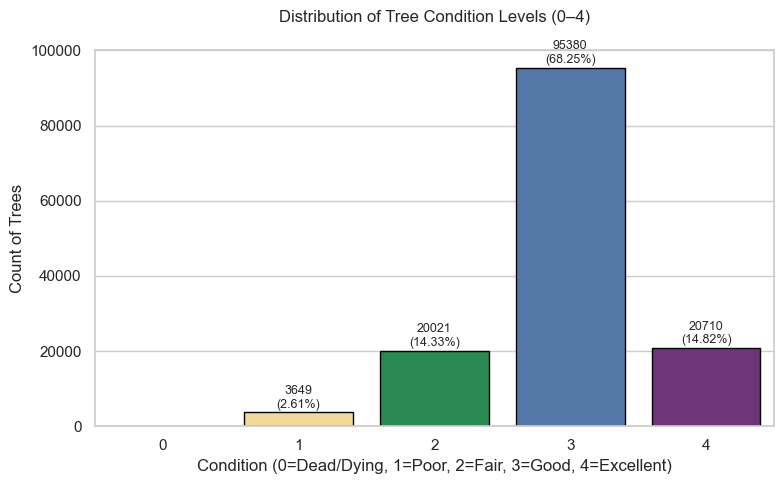

C:\Users\admin\AppData\Local\Temp\ipykernel_4184\2643655117.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


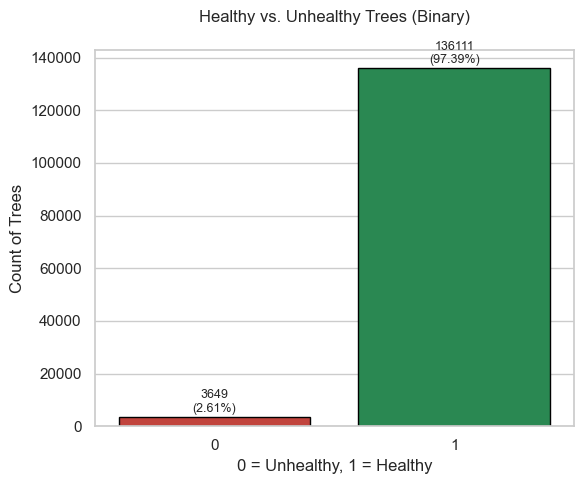

In [11]:
# --- 5-level condition (0=dead/dying ... 4=excellent) ---
order_num = [0, 1, 2, 3, 4]
palette_num = ["#d73027", "#fee08b", "#1a9850", "#4575b4", "#762a83"]  # red, yellow, green, blue, purple

plt.figure(figsize=(8,5))
sns.countplot(
    x=df["condition_numeric"].round().astype(int),
    order=order_num,
    palette=palette_num,
    edgecolor="black",
)
total = len(df)
for i, p in enumerate(plt.gca().patches):
    h = p.get_height()
    pct = 100*h/total
    plt.text(p.get_x()+p.get_width()/2, h + 500, f"{int(h)}\n({pct:.2f}%)",
             ha="center", va="bottom", fontsize=9)
plt.title("Distribution of Tree Condition Levels (0–4)", pad=20)
plt.xlabel("Condition (0=Dead/Dying, 1=Poor, 2=Fair, 3=Good, 4=Excellent)")
plt.ylabel("Count of Trees")
plt.tight_layout()
plt.show()


# --- Binary condition (0=Unhealthy, 1=Healthy) ---
binary_palette = ["#d73027", "#1a9850"]  # 0=red (unhealthy), 1=green (healthy)

plt.figure(figsize=(6,5))
sns.countplot(
    x="condition_binary",
    data=df,
    order=[0, 1],
    palette=binary_palette,
    edgecolor="black",
)
total = len(df)
for i, p in enumerate(plt.gca().patches):
    h = p.get_height()
    pct = 100*h/total
    plt.text(p.get_x()+p.get_width()/2, h + 500, f"{int(h)}\n({pct:.2f}%)",
             ha="center", va="bottom", fontsize=9)
plt.title("Healthy vs. Unhealthy Trees (Binary)", pad=20)
plt.xlabel("0 = Unhealthy, 1 = Healthy")
plt.ylabel("Count of Trees")
plt.tight_layout()
plt.show()

### 5.3 Correlation Analysis

Correlation Matrix:
                           condition_numeric  tree_age  longitude_coordinate  \
condition_numeric                      1.000    -0.320                -0.080   
tree_age                              -0.320     1.000                -0.140   
longitude_coordinate                  -0.080    -0.140                 1.000   
latitude_coordinate                    0.080     0.090                -0.510   
diameter_breast_height_CM             -0.290     0.570                -0.140   
ward                                  -0.110    -0.130                 0.750   
native                                -0.060     0.120                 0.030   
overhead_utility                      -0.030    -0.040                 0.100   

                           latitude_coordinate  diameter_breast_height_CM  \
condition_numeric                        0.080                     -0.290   
tree_age                                 0.090                      0.570   
longitude_coordinate        

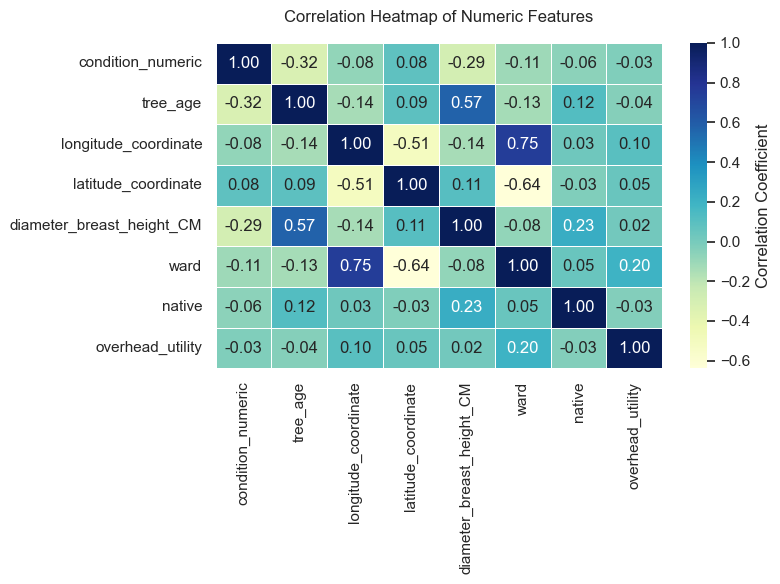

In [12]:
# Select only the numeric features used in the analysis
numeric_features = [
    "condition_numeric",
    "tree_age",
    "longitude_coordinate",
    "latitude_coordinate",
    "diameter_breast_height_CM",
    "ward",
    "native",
    "overhead_utility"
]

# Compute correlation matrix
corr_matrix = df[numeric_features].corr()

# Display correlation matrix values
print("Correlation Matrix:")
print(corr_matrix.round(2))

# Create heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap of Numeric Features", pad=15)
plt.tight_layout()
plt.show()

---

## Section 5. Results and Conclusions

TODO: Remove this: This is a Markdown cell. At the end of your notebook, summarize practical insights gained from your analysis. Be specific, data-driven, and present what useful insights (based on specific results) your analysis has shown. Summarize for the reader so they don't have to review the entire analysis, but they can.

TODO: Summarize your specific results and conclusions clearly.
From the chart, we can see that Adelie and Chinstrap penguins have very similar average body mass, while the Gentoo penguins are noticeably heavier.  
On average, Gentoo penguins weigh roughly **20% more** than the other two species.  


## Before Committing: Finalize and Run All before sending to GitHub

TODO: Remove this whole cell or confirm that you have reviewed your notebook for quality. This is a Markdown cell. Before committing a notebook, use 'Run All' to generate all outputs and display them in the notebook. Verify everything looks right before using git add-commit-push to save your work to GitHub. Confirm title block and intro are good, section headings are clear, visuals have clear captions, labels, axes, units, and legends. Professional analysis skills and professional communication skills are critical. 
